In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', 100)

In [2]:
Cases = pd.read_csv('data/Cases2018.csv', encoding='iso-8859-1')

In [3]:
unneeded =Cases[['caseId','docketId','lexisCite','term','naturalCourt','docket','chief','caseName','caseIssuesId','voteId','dateDecision', 'decisionType','usCite','sctCite','ledCite', 'issue','issueArea','decisionDirection','decisionDirectionDissent','authorityDecision1','authorityDecision2','lawType','lawSupp','lawMinor','majOpinWriter','majOpinAssigner']]
labels =Cases[['declarationUncon', 'caseDisposition', 'caseDispositionUnusual','partyWinning', 'precedentAlteration','voteUnclear','splitVote','majVotes','minVotes']]

In [4]:
Cases.drop(unneeded, axis=1, inplace=True)
Cases.drop(labels, axis=1, inplace=True)

##### Dates not important, just the fact oral arguments occured or not

In [7]:
Cases[['dateArgument','dateRearg']]=Cases[['dateArgument', 'dateRearg']].notnull().astype(int)

#### filling some NaN in petitioner/respondent state columns with 0 a variable to mean unspecified 

In [9]:
Cases[['petitionerState','adminActionState','threeJudgeFdc','respondentState',]] = Cases[['petitionerState','adminActionState','threeJudgeFdc','respondentState',]].fillna(value=0.0)
Cases['respondent'] = Cases[['respondent']].fillna(value=501)# There was already a code for unidentfiable which i reused for NaN here
Cases['adminAction'] = Cases[['adminAction']].fillna(value=118.0)# There was already a code for unidentfiable which i reused for NaN here
Cases['caseOrigin'] = Cases[['caseOrigin']].fillna(value=0.0)#meaning originated in supreme court
Cases['caseSource'] = Cases[['caseSource']].fillna(value=0.0)##meaning originated in supreme court
Cases['caseOriginState'] = Cases[['caseOriginState']].fillna(value=0.0)
Cases['caseSourceState'] = Cases[['caseSourceState']].fillna(value=0.0)
Cases['lcDisagreement'] = Cases[['lcDisagreement']].fillna(value=0.0)
Cases['certReason'] = Cases[['certReason']].fillna(value=12)
Cases['lcDisposition'] = Cases[['lcDisposition']].fillna(value=0.0)
Cases['lcDispositionDirection'] = Cases[['lcDispositionDirection']].fillna(value=3.0)

In [10]:
finalLabels = labels['partyWinning']

In [11]:
Cases['result'] = labels['partyWinning']

In [14]:
Cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8893 entries, 0 to 8892
Data columns (total 19 columns):
dateArgument              8893 non-null int32
dateRearg                 8893 non-null int32
petitioner                8893 non-null int64
petitionerState           8893 non-null float64
respondent                8893 non-null float64
respondentState           8893 non-null float64
jurisdiction              8893 non-null int64
adminAction               8893 non-null float64
adminActionState          8893 non-null float64
threeJudgeFdc             8893 non-null float64
caseOrigin                8893 non-null float64
caseOriginState           8893 non-null float64
caseSource                8893 non-null float64
caseSourceState           8893 non-null float64
lcDisagreement            8893 non-null float64
certReason                8893 non-null float64
lcDisposition             8893 non-null float64
lcDispositionDirection    8893 non-null float64
result                    8893 non-nu

In [13]:
Cases['result'] = Cases[['result']].fillna(value=2.0)

In [15]:
Cases.drop(Cases[Cases.result==2.0].index, inplace = True) 

In [16]:
labels2 = Cases[['result']]

In [17]:
Cases.drop('result', axis=1, inplace=True)

#### beginning preparation for GBoosted classifier

In [18]:
def cats(DF):
    for i in DF.columns:
        DF[i] = pd.Categorical(DF[i])
    return DF

In [19]:
cats(Cases)
Cases2 = Cases

In [20]:
len(Cases2.columns)

18

In [21]:
binCols = ['dateArgument', 'dateRearg','threeJudgeFdc','lcDisagreement']
# Takes all 14 other columns
dummy_cols = list(set(Cases2.columns) - set(binCols))

In [22]:
dummy_cols

['respondentState',
 'caseOriginState',
 'caseSource',
 'adminActionState',
 'caseSourceState',
 'caseOrigin',
 'lcDispositionDirection',
 'respondent',
 'lcDisposition',
 'petitioner',
 'jurisdiction',
 'adminAction',
 'certReason',
 'petitionerState']

In [23]:
Cases2 = pd.get_dummies(Cases2, columns=dummy_cols, drop_first=True)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(Cases2, labels2, test_size=0.2, random_state=23)

In [25]:
y_test = np.ravel(y_test)
y_train = np.ravel(y_train)

In [26]:
params = {'n_estimators': 4000, 'learning_rate': 0.01, 'random_state':23}
GBC = GradientBoostingClassifier(**params)

In [27]:
GBC.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=4000,
              n_iter_no_change=None, presort='auto', random_state=23,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [28]:
GBC.score(X_test, y_test)

0.6647887323943662

Text(0, 0.5, 'Deviance')

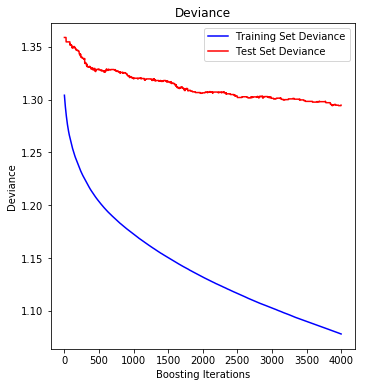

In [29]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(GBC.staged_predict(X_test)):
    test_score[i] = GBC.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, GBC.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [30]:
GBC.score(X_train, y_train)
5679/8874

0.6399594320486816

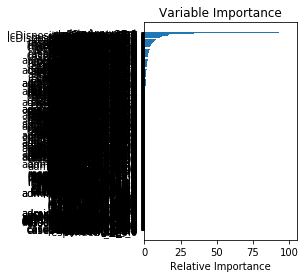

In [31]:
feature_importance = GBC.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, Cases2.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [38]:
Cases.groupby('lcDispositionDirection').count()

,dateArgument,dateRearg,petitioner,petitionerState,respondent,respondentState,jurisdiction,adminAction,adminActionState,threeJudgeFdc,caseOrigin,caseOriginState,caseSource,caseSourceState,lcDisagreement,certReason,lcDisposition
lcDispositionDirection,,,,,,,,,,,,,,,,,
1.0,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847
2.0,3747,3747,3747,3747,3747,3747,3747,3747,3747,3747,3747,3747,3747,3747,3747,3747,3747
3.0,280,280,280,280,280,280,280,280,280,280,280,280,280,280,280,280,280
